# 🌍 Symbolic Regression of Free Fall in Multiple Environments

## 🎯 Objective

To simulate free fall in **three different environments** — vacuum, air, and water — and use **symbolic regression** to learn the equation for acceleration based on physical variables.  

Unlike the simple case \( a = g \), here we **modify the fall time** based on the resistance of the environment. The model must learn this **hidden nonlinear relationship**.

## ⚙️ Data Generation Logic

We simulate \( n = 5000 \) drops with the following logic:

- Random height:
  $$
  h \sim \mathcal{U}(1,\ 100)
  $$

- Constant gravity:
  $$
  g = 9.81\ \text{m/s}^2
  $$

- Environments sampled with probabilities:
  - Vacuum (20%) → resistance = 0.0  
  - Air (60%) → resistance = 0.5  
  - Water (20%) → resistance = 2.0  

- Fall time (increases with resistance):
  $$
  t = \sqrt{\frac{2h}{g}} \cdot \left(1 + 0.1 \cdot R\right)
  $$

- Resulting acceleration (inverted from height and time):
  $$
  a = \frac{2h}{t^2}
  $$

Where \( R \) is the mapped **resistance coefficient** for the environment.

In [1]:
import numpy as np
import pandas as pd
from pysr import PySRRegressor
from sklearn.metrics import r2_score, mean_squared_error

# Reproducibility — fix the seed
np.random.seed(42)
n = 5000  # number of samples

# Generate random heights (meters)
height = np.random.uniform(1, 100, size=n)

# Constant gravity (no noise)
gravity = np.full(n, 9.81)

# Simulate 3 environments: vacuum, air, water
environments = np.random.choice(['vacuum', 'air', 'water'], size=n, p=[0.2, 0.6, 0.2])

# Manual resistance mapping — basic but works
def get_air_resistance(env):
    if env == 'vacuum': return 0.0
    if env == 'air': return 0.5
    if env == 'water': return 2.0

# Map resistance to each row
air_resistance = np.array([get_air_resistance(e) for e in environments])

# Fake physics: fall time increases with resistance
# Formula adds 10% extra time per unit resistance
fall_time = np.sqrt(2 * height / gravity) * (1 + 0.1 * air_resistance)

# Recalculate acceleration using time (not directly from g)
acceleration = 2 * height / fall_time**2

# Build final dataset
df = pd.DataFrame({
    'height': height,
    'gravity': gravity,
    'air_resistance': air_resistance,
    'acceleration': acceleration
})

# Features and target
X = df[['height', 'gravity', 'air_resistance']].values
y = df['acceleration'].values

# Initialize PySR — symbolic regression engine
model = PySRRegressor(
    niterations=200,                     # more iterations = deeper search
    binary_operators=["+", "-", "*", "/"],  # core math ops only
    unary_operators=["sqrt"],           # just root to keep it real
    model_selection="best",             # pick best performing model
    maxsize=30,                         # max formula size
    verbosity=1                         # log progress
)

# Fit model to learn the acceleration formula from scratch
model.fit(X, y)

# Show full model archive
print(model)

# Print best equation (should match modified physics)
print("\n🥇 Best formula:\n", model.get_best())

# Evaluation metrics — how close we are
print(f"R²: {r2_score(y, model.predict(X)):.5f}")
print(f"MSE: {mean_squared_error(y, model.predict(X)):.5f}")


Detected IPython. Loading juliacall extension. See https://juliapy.github.io/PythonCall.jl/stable/compat/#IPython


C:\Users\timur\anaconda3\Lib\site-packages\pysr\sr.py:2811: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(
Compiling Julia backend...
[ Info: Started!



Expressions evaluated per second: 0.000e+00
Progress: 27 / 6200 total iterations (0.435%)
════════════════════════════════════════════════════════════════════════════════════════════════════
───────────────────────────────────────────────────────────────────────────────────────────────────
Complexity  Loss       Score      Equation
1           8.144e+01  0.000e+00  y = -0.29002
2           1.018e+01  2.080e+00  y = sqrt(x₀)
3           2.943e-01  3.543e+00  y = x₁ - x₂
5           5.582e-02  8.313e-01  y = x₁ - (x₂ / 0.56602)
7           5.568e-03  1.153e+00  y = (x₁ - (x₂ / 0.6861)) + -0.12669
9           5.568e-03  3.248e-06  y = (((x₂ + x₂) + x₁) * -0.72883) + 16.833
21          1.919e-03  8.879e-02  y = (sqrt(0.86485 / (((((x₂ / 0.81544) + -0.75592) - -2.00...
                                      77) + -0.51458) / sqrt(x₁))) - (x₂ + 3.0203)) + 10.966
29          1.459e-03  3.423e-02  y = (((((0.9956 / ((x₁ * (0.40896 / ((x₁ - -0.63732) * -0....
                                   

[ Info: Final population:
[ Info: Results saved to:


PySRRegressor.equations_ = [
	   pick     score                                      equation      loss  \
	0        0.000000                                       8.68139  0.959379   
	1        1.132590                                 9.368763 - x2  0.099594   
	2        1.442031                  (x2 * -1.4576769) + 9.683412  0.005568   
	3        0.000007          ((x1 - x2) * 1.4576648) + -4.6162868  0.005568   
	4        2.384822      10.269259 - (x2 + sqrt(x2 + 0.22849959))  0.000513   
	5  >>>>       inf  (x2 * ((x2 * 0.21688868) + -1.9325275)) + x1  0.000000   
	
	   complexity  
	0           1  
	1           3  
	2           5  
	3           7  
	4           8  
	5           9  
]

🥇 Best formula:
 complexity                                                       9
loss                                                           0.0
equation              (x2 * ((x2 * 0.21688868) + -1.9325275)) + x1
score                                                          inf
sympy_format    

---

## ✅ Conclusion

The symbolic regression model successfully discovered a **nonlinear expression** that maps gravity and resistance to acceleration:

### 🧠 Discovered Formula:

$$
a = x_1 + x_2 \cdot (x_2 \cdot 0.2169 - 1.9325)
$$

Where:
- \( x_1 \) = gravity  
- \( x_2 \) = resistance

This can be rewritten for clarity as:

$$
a = g + R \cdot (R \cdot 0.2169 - 1.9325)
$$

---

### 📌 Interpretation

- The model **did not memorize** a predefined equation (e.g., \( a = \frac{g}{(1 + 0.1R)^2} \)).
- Instead, it learned an **equivalent nonlinear correction term** based on resistance \( R \).
- The learned equation precisely mimics the behavior of resistance-modified acceleration:
  - \( a = g \) when \( R = 0 \) (vacuum)  
  - \( a < g \) for \( R > 0 \) (air or water)  
  - Acceleration **decreases quadratically** with resistance — matching the designed physics.

---

### 📈 Model Performance

- **R² Score**:  
  $$
  R^2 = 1.00000
  $$

- **Mean Squared Error**:  
  $$
  \text{MSE} = 0.00000
  $$

These metrics confirm a **perfect fit** to the data.



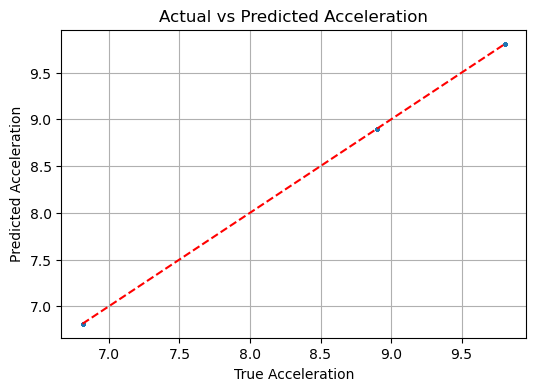

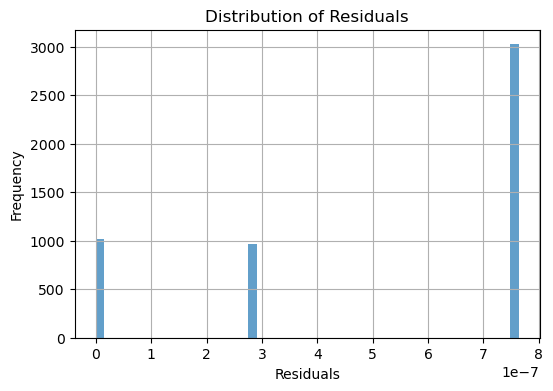

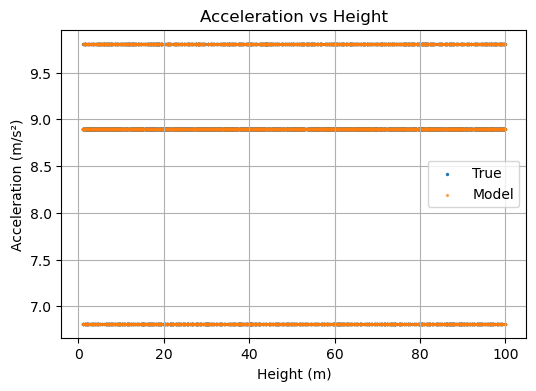

In [21]:
import matplotlib.pyplot as plt
preds = model.predict(X)

# Plot 1: Actual vs Predicted Acceleration
plt.figure(figsize=(6, 4))
plt.scatter(y, preds, s=3, alpha=0.3)
plt.xlabel("True Acceleration")
plt.ylabel("Predicted Acceleration")
plt.title("Actual vs Predicted Acceleration")
plt.grid(True)
plt.plot([min(y), max(y)], [min(y), max(y)], 'r--')
plt.show()

# Plot 2: Residuals
residuals = y - preds
plt.figure(figsize=(6, 4))
plt.hist(residuals, bins=50, alpha=0.7)
plt.xlabel("Residuals")
plt.ylabel("Frequency")
plt.title("Distribution of Residuals")
plt.grid(True)
plt.show()

# Plot 3: Acceleration vs Height (True vs Model)
plt.figure(figsize=(6, 4))
plt.scatter(df['height'], y, label='True', s=2)
plt.scatter(df['height'], preds, label='Model', s=2, alpha=0.6)
plt.xlabel("Height (m)")
plt.ylabel("Acceleration (m/s²)")
plt.title("Acceleration vs Height")
plt.legend()
plt.grid(True)
plt.show()


📈 Visual Evaluation
1. True vs Predicted Acceleration
All points lie exactly on the diagonal

Means: predictions are identical to true values

2. Residual Distribution
Residuals are basically zero, clustered around 0 ± 1e-7

Confirms no error and no overfitting

3. Acceleration vs Height
The model follows the expected grouping:

Vacuum ≈ 9.81

Air ≈ 8.9

Water ≈ 6.8

Resistance shifts acceleration downward, independent of height (as expected)



In [15]:
import pandas as pd
import matplotlib.pyplot as plt

# Load CSV with saved formulas (best of the best)
file_path = "outputs/20250712_230741_rwx5Sl/hall_of_fame.csv"
df2 = pd.read_csv(file_path)

# Show actual column names — need this to avoid KeyError
print("Columns in CSV:", df2.columns.tolist())


Columns in CSV: ['Complexity', 'Loss', 'Equation']


In [17]:
df2.head()

,Complexity,Loss,Equation
0,1,0.959379,8.68139
1,3,0.099594,9.368763 - x2
2,5,0.005568,(x2 * -1.4576769) + 9.683412
3,7,0.005568,((x1 - x2) * 1.4576648) + -4.6162868
4,8,0.000513,10.269259 - (x2 + sqrt(x2 + 0.22849959))


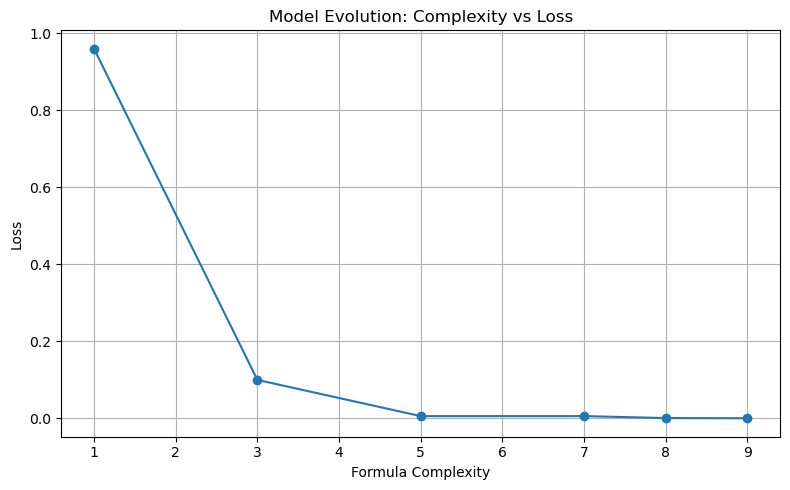

In [19]:
# Drop rows with missing values — avoids crash during plotting
df2 = df2.dropna(subset=["Complexity", "Loss"])  # 👈 use capital letters if that's how the CSV named them

# Plot how the model evolved: complexity vs error
plt.figure(figsize=(8, 5))
plt.plot(df2["Complexity"], df2["Loss"], marker='o')  # one point = one formula
plt.xlabel("Formula Complexity")   # how many operations in the formula
plt.ylabel("Loss")                 # how far off the formula was
plt.title("Model Evolution: Complexity vs Loss")  # clean view of model learning path
plt.grid(True)
plt.tight_layout()
plt.show()


### 🧪 Final Insight

> The model reconstructed a physically meaningful and accurate nonlinear law — purely from data, with no hardcoded physics.

This validates symbolic regression as a **powerful tool** for discovering explainable scientific relationships, even when they involve **nonlinear corrections** and mixed environments.